<a href="https://colab.research.google.com/github/kkhendry/QOSF-2021-Cohort-4-Hydra/blob/master/ColabMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To work using VSCode Editor, run cell 1 and 2 below.
Input your own ngrok authentication token in cell 1 and access the VSCode ngrok tunnel by clicking the link in cell 2.

In [1]:
#@title Cell 1
#%%capture uncomment in google colab to hide output
!pip install colabcode
!wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq -n ngrok-stable-linux-amd64.zip
!./ngrok authtoken 20U3834NIEtDeUcn98AGuj8rL7B_3trunaPVasZKZijiuZUCH #add your own authtoken here. Log in/sign up for an ngrok account at https://ngrok.com/.
from colabcode import ColabCode


In [ ]:
#@title Cell 2
ColabCode(port=10000)

To work from google colab, run cell 3. This option is great for running to notebook, but limited for editing helper and utility files and functions.

In [ ]:
#@title Cell 3
#%%capture uncomment in google colab to hide output
!git clone https://github.com/kkhendry/QOSF-2021-Cohort-4-Hydra.git
import sys
sys.path.insert(0, '/content/QOSF-2021-Cohort-4-Hydra/')
%cd QOSF-2021-Cohort-4-Hydra

Run cell 4 and 5 below to set up all the requirements to run the rest of the notebook. When dwave setup prompts you for an authentication token in cell 5, please use your own. You can sign up for a dwave leap account with limited usage at https://cloud.dwavesys.com/leap/login/?next=/leap/.

In [3]:
#@title Cell 4
#%%capture uncomment in google colab to hide output. if using vscode, simply copy and paste the code below in the terminal. For git config add your own email address and user name associated with your github account.
!git config --global user.email karan.khendry@gmail.com
!git config --global user.email hydraken
!pip install -r setup

In [11]:
#@title Cell 5
#%%capture uncomment in google colab to hide output. if using vscode, simply copy and past the code below in the terminal.
#API Token: DEV-4f5f3a7d07f2dc98dccd35b17cdbaf20b5b7e8cf #use your own dwave Leap API Token
# !dwave setup

Install all required modules in cell 6 below.

In [1]:
#@title Cell 6
#General
import numpy as np
import scipy
import scipy.linalg
import math
import time
import matplotlib.pyplot as plt

#Molecule Drivers
import pyscf
from pyscf import gto, scf, mcscf

##QISKIT
#Molecule, Fermioninc Operator, Problem Definition
from qiskit_nature.drivers import Molecule
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

#Properties
from qiskit_nature.properties import Property, GroupedProperty
from qiskit_nature.properties.second_quantization.electronic import (
    ElectronicEnergy,
    ElectronicDipoleMoment,
    ParticleNumber,
    AngularMomentum,
    Magnetization,
)
from qiskit_nature.properties.second_quantization.electronic.integrals import (
    ElectronicIntegrals,
    OneBodyElectronicIntegrals,
    TwoBodyElectronicIntegrals,
    IntegralProperty,
)
from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis

#Qubit Operator
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

#Circuits, Simulators, Algorithms, Solvers and VQE
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver

##OPENFERMION
from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
import numpy
import scipy
import scipy.linalg

##UTILITIES
from helper_functions import *
from XBK_method import *
from QCC_method import *

Set up the molecule and electronic structure rpoblem to work with in cell 7 below. Some molecule have been set up below, uncomment the relevant sections to run experiements with those or create an equivalent code block with a molecule of your choice.

In [2]:
#@title Cell 6

#H2
geometry = [['H', [  0.0,    0.0,    0.0]],
            ['H', [  0.0,    0.0,   0.739]]]
molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
mol_name = 'H2'
basis = 'sto6g'

#H3
# geometry = [['H', [0.0, 0.0, 0.0]], ['H', [1.1, 0.0, 0.0]], ['H', [0.55, 0.9526279441628825, 0]]]
# molecule = Molecule(geometry=geometry, charge=1, multiplicity=1)
# mol_name = 'H3'
# basis = 'sto3g'

# #LiH
# geometry = [['Li', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.5474]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# mol_name = 'LiH'
# basis = 'sto3g'

# # H20
# geometry = [['O', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 1.0]], ['H', [0.0, 1.0, 0.0]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# mol_name = 'H20'
# basis = 'sto3g'

# #HCONH2
# geometry = [["O",  [1.1280, 0.2091, 0.0000]],
#             ["N", [-1.1878, 0.1791, 0.0000]],
#             ["C", [0.0598, -0.3882, 0.0000]],
#             ["H", [-1.3085, 1.1864, 0.0001]],
#             ["H", [-2.0305, -0.3861, -0.0001]],
#             ["H", [-0.0014, -1.4883, -0.0001]],
#             ['C', [-0.1805, 1.3955, 0.000]]]
# molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)
# mol_name = 'HCONH2'
# basis = 'sto3g'

driver = ElectronicStructureMoleculeDriver(molecule=molecule, 
                                           basis=basis, 
                                           driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
q_fermionic_op = second_q_op[0]
register_length = q_fermionic_op.register_length
of_fermionic_op = qiskit2of_fermionicOp(q_fermionic_op)

qubit_converter = QubitConverter(JordanWignerMapper())
qubit_op = qubit_converter.convert(q_fermionic_op)

init_state = HartreeFock(es_problem.num_spin_orbitals, es_problem.num_particles, qubit_converter)
# init_state.draw()

ansatz = UCCSD(qubit_converter, es_problem.num_particles, es_problem.num_spin_orbitals, initial_state = init_state)
# ansatz.decompose().draw(output = "mpl")
# ansatz = TwoLocal(rotation_blocks = ['h', 'rx', 'ry'], entanglement_blocks = 'cz', entanglement='linear', reps=3)
# ansatz.draw(output = "mpl")

qubit_H = jordan_wigner(of_fermionic_op)
m = count_qubits(qubit_H)
# print(qubit_H)

Set up the IBM Quantum Device backend in cell 7 below. DO not run cell 7 if you would like to use a simulator. Please use your own IBM Quantum authentication API token. You can login/sign up for an IBM Quantum account at https://quantum-computing.ibm.com/

In [8]:
#@title Cell 7

from qiskit import IBMQ
IBMQ.save_account('f10a5be117c16a6472c748a25874a94883f6021cf9bfe6f406e015522235a968d8eb0a5812f47160385c72355172371278d3c36e75e23fc7f4d73f1523fcbdf8')
provider = IBMQ.load_account()
# provider = IBMQ.get_provider(project='qiskit-runtime')  # Change this to your provider.

Run cell 8 below to set up the quantum annealer simulator or device. Uncomment as applicable.

In [3]:
#@title Cell 8
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

# from dwave.system import LeapHybridSampler
# sampler = LeapHybridSampler()

Run cell 9 to get the classical solution for the exact electronic energy, this may not be feasible for large molecules. (Isn't that the point?)

In [4]:
#@title Cell 9
numpy_solver = NumPyMinimumEigensolver()
numpy_ground_state_solver = GroundStateEigensolver(qubit_converter, numpy_solver)
numpy_results = numpy_ground_state_solver.solve(es_problem)

exact_energy = numpy_results.computed_energies[0]
print(f"Exact electronic energy: {exact_energy:.6f} Hartree\n")
print(numpy_results)

Exact electronic energy: -1.862023 Hartree

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.862022752293
  - computed part:      -1.862022752293
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.145950748341
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


Exact Electronic Energy = -1.853364
Minimum Eigenvalue = -1.849370
Nominal Chemical Accuracy = 0.003994+0.000000j mHa
Percent Chemical Accuracy = 99.784 %
Minimum Eigenstate = {'0101': 0.9831073186585481, '0110': 0.057008771254956896, '1001': 0.03162277660168379, '1010': 0.1710263137648707}
Optimal Point = [0.06082656 0.03449301 0.18790866]
Min Energy = -1.8493696149337433 Error = -0.003994003738295948 mHa (0.0021550027733671104%) Runtime = 1659.7159061431885
ipykernel_launcher:41: ComplexWarning: Casting complex values to real discards the imaginary part


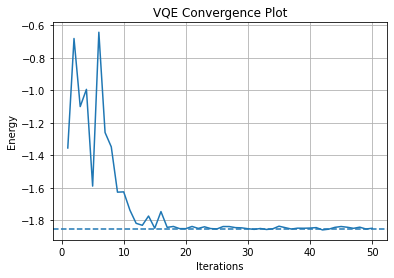

In [25]:
backend = provider.get_backend('ibmq_qasm_simulator')
optimizer = COBYLA()

error_threshold = 10 # mHartree

np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

start_time = time.time()
result = algorithm.compute_minimum_eigenvalue(qubit_op)
percent_accuracy = 100-np.abs(100*(result.eigenvalue-exact_energy)/exact_energy)
nominal_accuracy = result.eigenvalue-exact_energy

end_time = time.time() - start_time

print('Exact Electronic Energy = %f' %exact_energy)
print('Minimum Eigenvalue = %f' %result.eigenvalue)
print('Nominal Chemical Accuracy = {:.6f}'.format(nominal_accuracy), 'mHa')
print('Percent Chemical Accuracy = {:.3f}'.format(percent_accuracy), '%')
print('Minimum Eigenstate = %s' %result.eigenstate)
print('Optimal Point = %s' %result.optimal_point)

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
# fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title("VQE Convergence Plot")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
print("Min Energy = " + str(result.eigenvalue.real), "Error = " + str(exact_energy - result.eigenvalue.real) + " mHa (" + str((exact_energy - result.eigenvalue.real)/exact_energy) + "%)", "Runtime = " + str(end_time))
# fig_title = f"\
# {result_dict['optimizer']}-\
# {result_dict['mapping']}-\
# {result_dict['ansatz']}-\
# Energy({result_dict['energy (Ha)']:.3f})-\
# Score({result_dict['score']:.0f})\
# .png"


# vqe = VQEUCCFactory(backend)
# vqe_ground_state_solver = GroundStateEigensolver(qubit_converter, vqe)
# vqe_results = vqe_ground_state_solver.solve(es_problem)

# print(vqe_results)

# error = (vqe_results.computed_energies[0] - exact_energy) * 1000 # mHartree
# print(f'Error is: {error:.3f} mHartree')

In [9]:
### QCC method ###
# print(qubit_H)
#set number of Bloch angle and entangler amplitude foldings
start_time = time.time()

angle_folds = 4
amplitude_folds = 1

#create dictionary of QubitOperator entanglers
entanglers = {'IYZI': QubitOperator('Y1 Z2'), 'IZYI': QubitOperator('Z1 Y2'),
              'IXYI': QubitOperator('X1 Y2'), 'IYXI': QubitOperator('Y1 X2')}

#run QCC method
QCC_energy, variables, min_energies, iter_times = QCC(qubit_H, entanglers, angle_folds, amplitude_folds, sampler, num_cycles=10, num_samples=1000, strength=1e3, verbose=True)
end_time = time.time() - start_time    
print(QCC_energy)
print(variables)
print(iter_times)


fig, ax1 = plt.subplots(1, 1)
color = 'tab:blue'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Energy')
# ax1.grid()
ax1.plot(range(len(min_energies)), min_energies)
ax1.axhline(exact_energy, linestyle='--')


ax2 = ax1.twinx() 
color = 'tab:orange'
ax2.set_ylabel('Time')
# ax2.plot(range(len(min_energies)), iter_times)

# fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title("QCC Convergence Plot")

print("Min Energy = " + str(QCC_energy), "Error = " + str(exact_energy - QCC_energy) + " mHa (" + str((exact_energy - QCC_energy)/exact_energy) + "%)", "Runtime = " + str(end_time))

-0.819476273820261 + 0.173455876425147*Z0*cos(the0) - 0.222425691975333*Z1*cos(the1) + 0.173455876425147*Z2*cos(the2) - 0.222425691975333*Z3*cos(the3) + (1 - cos(tau0))*(0.222425691975333*Z1*cos(the1) - 0.120779207929492*Z1*Z0*cos(the1)*cos(the0) - 0.166139664061611*Z2*Z1*cos(the1)*cos(the2) - 0.174855520523933*Z3*Z1*cos(the1)*cos(the3) - 0.0453604561321193*Q0*Q1*sin(the1)*sin(the2)*sin(the3)*sin(the0)*sin(phi1)*sin(phi0)*cos(phi3)*cos(phi2) - 0.0453604561321193*Q0*Q3*Q1*Q2*sin(the1)*sin(the2)*sin(the3)*sin(the0)*sin(phi3)*sin(phi1)*sin(phi0)*sin(phi2)) + (1 - cos(tau1))*(-0.173455876425147*Z2*cos(the2) - 0.168722640414494*Z2*Z0*cos(the0)*cos(the2) - 0.166139664061611*Z2*Z1*cos(the1)*cos(the2) - 0.120779207929492*Z3*Z2*cos(the3)*cos(the2) - 0.0453604561321193*Q3*Q2*sin(the1)*sin(the2)*sin(the3)*sin(the0)*sin(phi3)*cos(phi0)*sin(phi2)*cos(phi1) - 0.0453604561321193*Q0*Q3*Q1*Q2*sin(the1)*sin(the2)*sin(the3)*sin(the0)*sin(phi3)*sin(phi1)*sin(phi0)*sin(phi2)) + (1 - cos(tau2))*(0.222425691

AttributeError: 'dict' object has no attribute 'vartype'

P: 0 E: -0.98672
P: 1 E: -1.01435
P: 2 E: -1.20952
Energy: -1.20952
-1.2095197486924
[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
[-0.98672079504468, -1.01435061791562, -1.2095197486924]
[0.08934950828552246, 0.08050727844238281, 0.08012700080871582]
Min Energy = -1.2095197486924 Error = -0.6525030036002932 mHa (0.350426976682681%) Runtime = 1.8608269691467285


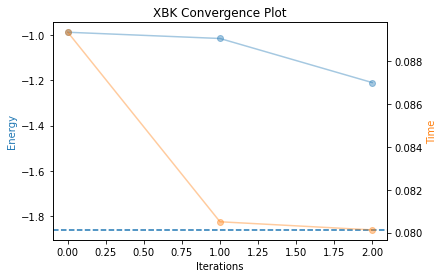

In [7]:
### XBK method ###

start_time = time.time()
#set r value
r = 4

#construct qubit Hamiltonians and C terms for XBK method
qubit_Hs, qubit_Cs = [],[]
for p in range(int(math.ceil(r/2+1))):
    qubit_Hs += [XBK_transform(qubit_H, r, p)]
    qubit_Cs += [construct_C(m, r, p)]

#run XBK method
XBK_energy, ground_state, min_energies, iter_times = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=0, num_samples=1000, strength=1e3, verbose=True)
end_time = time.time() - start_time
print(XBK_energy)
print(ground_state) #ground state in rm-qubit space
print(min_energies)
print(iter_times)

fig, ax1 = plt.subplots(1, 1)
color = 'tab:blue'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Energy', color=color)
# ax1.grid()
ax1.plot(range(len(min_energies)), min_energies, color=color, marker='o', alpha = 0.4)
ax1.axhline(exact_energy, linestyle='--')

ax2 = ax1.twinx() 
color = 'tab:orange'
ax2.set_ylabel('Time', color=color)
ax2.plot(range(len(min_energies)), iter_times, color=color, marker='o', alpha = 0.4)

# fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title("XBK Convergence Plot")
print("Min Energy = " + str(XBK_energy), "Error = " + str(exact_energy - XBK_energy) + " mHa (" + str((exact_energy - XBK_energy)/exact_energy) + "%)", "Runtime = " + str(end_time))

In [ ]:
mol_dict = {mol_name: mol_name,'basis': basis, 'q_fermionic_op' : str(q_fermionic_op.to_list())}

import json
with open(mol_name + '.json','w') as file:
      json.dump(mol_dict, file, sort_keys=True, indent=4)
        
qcc_op_list = list(str(qubit_op_to_expr(qubit_H)).split('+'))
print(*qcc_op_list, sep = "\n")   

properties = driver.run()
electronic_energy = properties.get_property(ElectronicEnergy)
particle_number = properties.get_property(ParticleNumber)
num_electron = sum(particle_number.num_particles)
num_MO = num_electron
num_SO = particle_number.num_spin_orbitals